# Laser Systems Performance

## Introduction

This notebook is an example collection of introductory examples of performance predicton for laser systems.

The first part of information in this notebook comes from \cite{willers2013}, the later information is new material.

The present form of this notebook does not yet consider gaussian beam shape effects.

The present form of this notebook does not yet consider turbulence effects.

All of the derivatiions below assume that the laser spot is smaller than the sensor FOV and fully contained in the sensor FOV.

## Prepare Python Environment

In [1]:
# to prepare the Python environment
import numpy as np
import scipy as sp
import scipy.constants as const
import pandas as pd
import os.path
import time
from scipy.optimize import curve_fit
from scipy import interpolate
import warnings
import gc

from scipy.interpolate import interp1d
from scipy.optimize import fsolve
%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck
import pyradi.ryfiles as ryfiles
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

import matplotlib as mpl
mpl.rc("savefig", dpi=72)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 80)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 150)

# suppress the pytables performance warning
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

### Simplified Range Equation

It is frequently necessary to determine the operational detection distance of a source and sensor combination. The problem is usually stated as follows: 
What operating detection range can be achieved with a given source intensity, atmospheric attenuation, and sensor sensitivity?  
Calculate the inband irradiance

\begin{equation}
E_\mathcal{S}=\frac{v_\mathcal{S}}{ k \,\widehat{\mathcal{R}}\,Z_t\,A_1}
=
\int_{A_0} \left(
\frac{1}{R_{01}^2}
\int_{0}^{\infty}
 \epsilon_{0\lambda} L_{0\lambda}
\,\tau_{a\lambda}(R) 
{\mathcal{S}}_\lambda d\lambda
\right) dA_{0}\,\cos\theta_0
\end{equation}

The objective is to solve for $R$ where the irradiance $E_{{\cal S}}=E_{{\cal S}\theta}$ is at the threshold at which the range must be determined. 
Normally, $E_{\mathcal{S}\theta}=\textrm{SNR}\times\textrm{NEE}$ where the $\textrm{SNR}$ is selected to yield a given probability of detection. Typical values for for single detector systems $\textrm{SNR}$ is around five. The atmospheric transmittance $\tau_{a\lambda}$ is a complex function of the path profile, the spectral band and the downrange distance $R$. 
Assuming a target smaller than the sensor field of view, and using the effective transmittance, the equation can be simplified to the form

\begin{equation}
E_{\mathcal{S}\theta}=\frac{I_{\mathcal{S}} \tau_{a\lambda}(R)}{R^2}
\end{equation}


Rewrite this equation as 
\begin{equation}
\frac{I}{E}=
\frac{I_{{\cal S}}}{E_{{\cal S}\theta}}=
\frac{R^2}{\tau_{a\lambda}(R)},\label{oplos}
\end{equation}
where the left side is a constant given by the source intensity $I_{{\cal S}}$ and threshold irradiance $E_{{\cal S}\theta}$, whereas the right side describes the range-related terms. In most cases the solution is not analytical and requires an iterative numerical solution.\cite{Kaminski1980,Tomiyama1982} A numerical solution is shown below for the grossly simplified case of a uniform atmosphere and constant spectral transmittance over the band, then $\tau_{a\lambda}(R)=\exp^{-\gamma R}$.  In practice, this is not good enough an approximation for any real system.


In [2]:
# to demonstrate the simple range equation solution
##############################################################################
##
def _rangeEquationCalc(r,i,e,tauTable,n,rMax):
    if r > rMax:
        print('\n\n***** range estimate of {0} exceed the lookup table range of {1}\n\n'.format(r[0],rMax))
        return 0
    return i * tauTable(r) / (r ** n) - e

##############################################################################
##
def rangeEquation(Intensity, Irradiance, rangeTab, tauTab, rangeGuess = 1, n = 2):
    """ 
    """

    tauTable = interp1d(rangeTab, tauTab, kind = 'linear')

    Range = fsolve(_rangeEquationCalc, rangeGuess,
        args = (Intensity,Irradiance,tauTable,n,np.max(rangeTab),))

    if(Range < rangeTab[2] ):
        print('\n\n***** range estimate of {0} might be invalid,'.format(Range[0])
            + ' increase lookup table resolution at close range\n\n')
        Range = - Range

    return Range

##############################################################################
##
#demonstrate the range equation solver
#create a range table and its associated (simplified!) transmittance table
rangeTab = np.linspace(0, 10000, 1000)
tauTab = np.exp(- 0.00015 * rangeTab) # gamma 0.15/km
Intensity=200
Irradiance=10e-6
r = rangeEquation(Intensity = Intensity, Irradiance = Irradiance, rangeTab = rangeTab,
      tauTab = tauTab, rangeGuess = 1, n = 2)
#test the solution by calculating the irradiance at this range.
tauTable = interp1d(rangeTab, tauTab, kind = 'linear')
irrad = Intensity * tauTable(r) / r ** 2

print(f'Range equation solver: the irradiance is {irrad[0]:.2e} W/m2 at a range {r[0]:.0f} m, ',end='')
print(f'with an irradiance error of {100*(irrad[0] - Irradiance) / Irradiance:.2e} %')

Range equation solver: the irradiance is 1.00e-05 W/m2 at a range 3452 m, with an irradiance error of 1.19e-12 %


The pyradi.ryutils module provides a function to solve the range equation for any abritrary atmospheric transmittance curve. 
The transmittance is taken from a lookup table of atmospheric transmittance vs. range. The transmittance lookup table  can be calculated from the simple Bouguer law, or it can have any arbitrary shape, provided it decreases with increasing range. The user supplies the lookup table in the form of an array of range values and an associated array of transmittance values.  The range values need not be on constant linear range increment.

The range equation is solved for two cases:

* n=2 (default value) the general case of a radiating source smaller than the field of view, viewed against the ground.

* n=4 the special case of a laser range finder illuminating a target smaller than the field of view, viewed against the sky. In this case there $R^2$ attenuation from the laser to the source and another $R^2$ attenuation from the source to the receiver, hence $R^4$ overall.

In [3]:
# to demonstrate the range equation solver
#create a range table and its associated transmittance table
print('The first case should give an incorrect warning:')
rangeTab = np.linspace(0, 20000, 10000)
tauTab = np.exp(- 0.00015 * rangeTab)
Intensity=200
Irradiancetab=[1e-100, 1e-7, 10e-6, 10e-1]
for Irradiance in Irradiancetab:
    r = ryutils.rangeEquation(Intensity = Intensity, Irradiance = Irradiance, rangeTab = rangeTab,
          tauTab = tauTab, rangeGuess = 1, n = 2)

    #test the solution by calculating the irradiance at this range.
    tauTable = interp1d(rangeTab, tauTab, kind = 'linear')

    if np.abs(r[0]) < rangeTab[2]:
        rr = rangeTab[2]
        strError = "Check range resolution in lookup table"
    elif np.abs(r[0]) > rangeTab[-1]:
        rr = rangeTab[-1]
        strError = "Check maximum range in lookup table"
    else:
        rr = r[0]
        strError = ""

    irrad = Intensity * tauTable(rr) / rr ** 2

    print(f'\nAt range {r[0]:.3e} the irradiance is {irrad:.3e},', end='')
    print(f'error is { 100*(irrad - Irradiance) / Irradiance:.3e} % {strError}')
print(' ')

The first case should give an incorrect warning:

At range -2.085e+04 the irradiance is 2.489e-08,error is 2.489e+94 % Check maximum range in lookup table

At range 1.477e+04 the irradiance is 1.000e-07,error is 8.034e-12 % 

At range 3.452e+03 the irradiance is 1.000e-05,error is 1.237e-12 % 

At range 1.413e+01 the irradiance is 1.000e+00,error is 5.551e-13 % 
 



The range equation can also be solved graphically by plotting the ratio $I/E$ for various atmospheric conditions, as function of range. This is shown on the right  figure below, where the $R^2/\exp(-\gamma R)$ curves indicate the detection ranges on the y axis for the values of $I/E$ on the x axis.
 

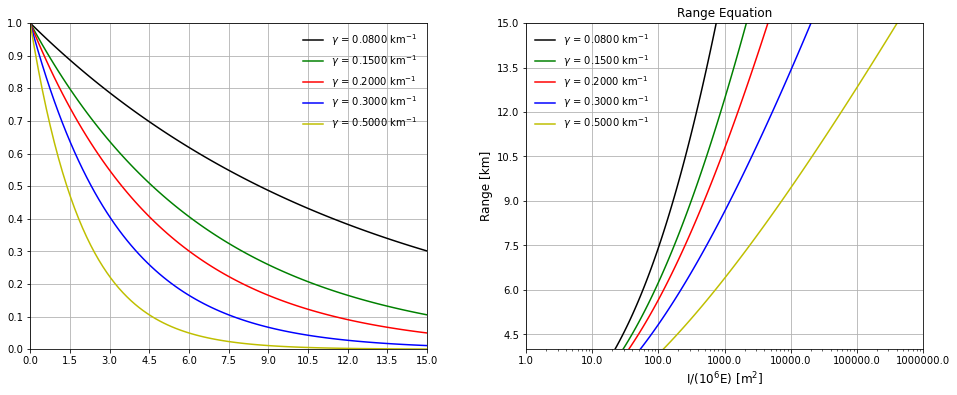

In [4]:
# to plot the simple range equation solution
pcol = ['k','g','r','b','y']
gamma = np.array([0.08, 0.15, 0.2, 0.3, 0.5] ) # /km
gammam = gamma / 1000 #  /m
Range = np.linspace(0.0000001,15100,100)
p = ryplot.Plotter(1,1,2,figsize=(16,6))
for i,gammami in enumerate(gammam):
    IoE =  (Range * Range) / (np.exp(-gammami * Range));
    p.plot(1,Range/1000,np.exp(-gammami * Range),label=[f'$\gamma$ = {1000*gammami:.4f} km$^{{-1}}$ '],
           pltaxis=[0,15,0,1],plotCol=pcol[i])
    p.semilogX(2, IoE/1e6,Range/1000,'Range Equation','I/(10$^6}$E) [m$^2$]','Range [km]',
               label=[f'$\gamma$ = {1000*gammami:.4f} km$^{{-1}}$ '],pltaxis=[1e1,1e5,4,15],plotCol=pcol[i])


## Range Performance Prediction


This section derives a simplified range equation for a laser target designator. Several simplifying assumptions are made in order to simplify the problem and emphasize the methodology in this first order analysis --- a more advanced analysis should follow.
The objective with this analysis is to derive an expression for the SNR for the laser designator. The  SNR can then be used to investigate the effect of several design parameters on system performance. For another approach to the range equation for laser rangefinders, see Kaminsky's paper.

### Noise equivalent irradiance

The noise equivalent irradiance in the receiver is given by
\begin{eqnarray}
E_n&=& \frac{
\sqrt{\Delta f A_d}
}{
D^\ast A_1 \tau_a
},
\end{eqnarray}
where
$A_d$ is the detector area,
$\Delta f$ is the noise bandwidth in the receiver,
$A_1$ is the receiver aperture area, and
$\tau_a$ is the receiver filter transmittance. The
$D^\ast$ values can include all of the relevant noise terms such as detector noise, amplifier noise, background induced noise, and system noise. The method whereby these noises are all combined into a single $D^\ast$ is described in [W]. For the purposes of this investigation, we will only work with a single $D^\ast$, assuming that all noise sources are incorporated in this value.

![images/rangelay.png](images/rangelay.png)

### Signal irradiance

The geometrical relationship between the laser transmitter, the object, and the laser receiver is shown in the layout diagram. The laser power or flux is denoted by $\Phi_L$ (in watts), the distance from the laser to the object is $R_{LO}$, and the distance from the object to the receiver is $R_{OR}$. The illuminated object-surface normal vector makes an angle $\theta_{LO}$ with the laser illumination direction, and an angle $\theta_{OR}$ with the receiver sightline direction.

The receiver and transmitter fields are not necessarily co-axial, because the receiver and transmitter are located at the same position. Different atmospheric transmittance values apply to the two optical paths.

The laser beam radiance is calculated from the  the optical power, beam area at the source and beam solid angle (divergence).  In order to use this very simple equation, the Gaussian shape properties of the laser beam is discarded for two very simple uniform shapes.
The laser beam angular radiance distribution is assumed to be uniform within the top-hat-shaped beam divergence profile (e.g., peak normalized divergence). The laser beam power distribution is assumed to be uniform across the area of the beam (e.g., peak normalized area). The radiance can be written as
\begin{equation}
L_L=\frac{\Phi_L}{\Omega_L A_L},
\end{equation}
where $\Omega_L$ is the laser beam solid angle, and $A_L$ is the laser beam cross-section area at the laser source. This simplification might not satisfy the required mathematical rigor, but it does provide order-of-magnitude radiance estimates.

The irradiance on the object is then
\begin{eqnarray}
E_O&=&\frac{L_L A_L \tau_{OL}\;\cos\theta_L\cos\theta_{LO}}{R^2_{LO}}\nonumber\\
&=&\frac{\Phi_L \tau_{OL}\cos\theta_{LO}}{\Omega_L R^2_{LO}},
\end{eqnarray}
where it is assumed that $\cos\theta_{L}=1$ because the laser beam radiates perpendicularly from the laser exit pupil. The uncooperative target object can have any orientation relative to the laser beam, denoted by $\theta_{LO}$.


### Lambertian target reflectance


The laser pulse falling onto the object is reflected by the object. Most
natural surfaces have diffuse reflectance and scatter energy in all
directions (a Lambertian source). The reflected laser spot on the target object has a radiance of
\begin{equation}
L_O=\frac{\rho E_O}{\pi}=\frac{\rho\Phi_L \tau_{LO}\cos\theta_{LO}}{\Omega_L
\pi R^2_{LO}}
\end{equation}

The irradiance, caused by the reflected pulse, at the laser receiver is then
\begin{eqnarray}
E_R&=&\frac{\Phi_R}{d A_1}\nonumber \\
&=&\frac{L_O A_O \cos\theta_{OR}\tau_{OR}}{R_{OR}^2},
\end{eqnarray}
where $A_O$ is the area illuminated by the laser that is visible to the
sensor. Further manipulation using Equation~\ref{loo} leads to
\begin{eqnarray}
E_R
&=&
\frac{\Phi_L \tau_{LO}\cos\theta_{LO}\rho A_O \cos\theta_{OR}\tau_{OR}}
{\Omega_L \pi R^2_{OR}R^2_{LO}}\nonumber \\
&=&
\frac{
\rho \Phi_L \tau_{LO} \cos\theta_{LO} A_O \cos\theta_{OR} \tau_{OR}
}{
\pi \Omega_L R^2_{LO}R^2_{OR}
}
\end{eqnarray}

This equation is similar to the radar range equation. The product

\begin{equation}
\rho\cos\theta_{LO} A_O \cos\theta_{OR} A_O
\end{equation}
can be regarded as the target optical cross-section. In the radar case, the optical cross section has a fixed magnitude irrespective of distance between the laser and target object. This is also true for a laser rangefinder illuminating an airborne object where there is no reflective background.  If the object is observed against a terrain background, the terrain background also contributes to the reflected signal (depending on the geometry).


### Signal to noise ratio: Single Detector

The rangefinder irradiance $\mathrm{SNR}$ is the ratio of signal strength
 to noise , and is given by
\begin{eqnarray}
\frac{E_R}{E_n}
&=&\frac{
\frac{
\rho \Phi_L \tau_{LO} \cos\theta_{LO} A_O \cos\theta_{OR} \tau_{OR}
}{
\pi \Omega_L R^2_{LO}R^2_{OR}
}
}{\frac{
\sqrt{\Delta f A_d}
}{
D^\ast A_1 \tau_a}
}\\
&=&
\frac{
\rho \Phi_L \tau_{LO} \cos\theta_{LO} A_O \cos\theta_{OR} \tau_{OR}D^\ast A_1 \tau_a
}{
\pi \Omega_L R^2_{LO}R^2_{OR}\sqrt{\Delta f A_d}
}
\end{eqnarray}

The laser flux is given by $\Phi_L\approx Q_L/t_p$, where $Q_L$ is the pulse
energy in [J], and $t_p$ is the pulse width in [s]. The required receiver
electronic noise bandwidth can be written in terms of the pulse width as
$\Delta f=k_nk_f/t_p$, where
$k_n$ relates the electrical system electronic bandwidth with the noise equivalent bandwidth, and
$k_f$ relates the laser pulse width with the system electronic bandwidth.

\begin{eqnarray}
\mathrm{SNR} &=& \frac{E_R}{E_n}\nonumber\\
&=&
\frac{
\rho Q_L \tau_{LO}\tau_{OR} \cos\theta_{LO} A_O \cos\theta_{OR} D^\ast A_1 \tau_a
}{
\pi \sqrt{t_p k_nk_f}\Omega_L R^2_{LO}R^2_{OR}\sqrt{A_d}
}\\
&=&
\overbrace{
\left(\frac{\rho A_O \cos\theta_{LO}  \cos\theta_{OR}D^\ast}{\pi\sqrt{k_n k_f}}\right)
}^{\textrm{no control}}
\overbrace{
\left(\frac{Q_L A_1 \tau_a}{\Omega_L\sqrt{t_p A_d }}\right)
}^{\textrm{design}}
\overbrace{
\left(\frac{\tau_{LO}\tau_{OR}}{R^2_{LO}R^2_{OR}}\right)
}^{\textrm{distance}}
\end{eqnarray}

This form describes the range finder performance of a target of finite size, smaller than the detector footprint, when viewed against the sky.  The laser energy not reflected from the target passes by the target and it lost.

If the laser rangefinder is viewing targets against the terrain, the laser light is reflected from the target object as well as its  surrounding terrain. This implies that the real target area is not of primary importance because the terrain background also reflects the laser pulse. Provided that the sensor field of view is larger than the laser beam spot size, note that $\Omega_L = \cos\theta_{LO} A_O/R^2_{OL}$ can the irradiance $\mathrm{SNR}$ now be written as

\begin{eqnarray}
\mathrm{SNR} &=&
\left(\frac{\rho  \cos\theta_{OR}D^\ast}{\pi\sqrt{k_n k_f}}\right)
\left(\frac{Q_L A_1 \tau_a}{\sqrt{t_p A_d }}\right)
\left(\frac{\tau_{LO}\tau_{OR}}{R^2_{OR}}\right)
\end{eqnarray}



This equation describes the laser designator system signal to noise ratio.
There are three groups of variables:


1.
Variables and constants that the designer has no control over, such as the object orientation and reflectivity, $D^\ast$, and constants.

2.
Variables that the designer controls in the design process, such as laser energy, receiver aperture area, laser pulse width, and detector size.

3.
Distance-related factors that the designer has little control over.


The designer can now easily determine that increased laser energy and receiver aperture improves the $\mathrm{SNR}$ linearly, whereas increased detector area and pulse width decrease the  $\mathrm{SNR}$. Contrary to intuition, a longer pulse width (i.e., a lower electronic bandwidth) decreases the  $\mathrm{SNR}$. Why?

An estimate of the detection range can be obtained by solving for the range $R_{OR}$ in the range equations, where  $\mathrm{SNR}$ is the signal-to-noise ratio required to achieve detection or tracking. Note that $R_{OR}$ appears explicitly in the denominator as $R^2_{OR}$ and implicitly the numerator in the transmittance term $\tau_{OR}$.


### Signal to noise ratio: Quadrant Detector

If the laser receiver has a quadrant detector,  the area per quadrant is 25\% of the total detector area. Furthermore, the defocussed laser spot spreads the flux approximately equally over the four quadrants.  This means that the $\mathrm{SNR} $ per quadrant will be

\begin{eqnarray}
\mathrm{SNR} _Q
&=&
\left(\frac{\rho  \cos\theta_{OR}D^\ast}{\pi\sqrt{k_n k_f}}\right)
\left(\frac{(Q_L/4) A_1 \tau_a}{\sqrt{t_p (A_d/4) }}\right)
\left(\frac{\tau_{LO}\tau_{OR}}{R^2_{OR}}\right)\\
&=&
\left(\frac{\rho  \cos\theta_{OR}D^\ast}{2\pi\sqrt{k_n k_f}}\right)
\left(\frac{Q_L A_1 \tau_a}{\sqrt{t_p A_d }}\right)
\left(\frac{\tau_{LO}\tau_{OR}}{R^2_{OR}}\right)
\end{eqnarray}


### Example calculation

The laser range equation can be solved for a given set of design choices and $\mathrm{SNR}$. The example calculation shown here is for a horizontal path near ground level under different atmospheric conditions.  The values shown in the following table were used in the calculation.



The atmospheric attenuation coefficients at the laser wavelength of 1.06~$\mu$m are taken from page 89 of the RCA Electro-Optics Handbook (also known as the Burle Electro-Optics Handbook).  These values apply to a homogeneous atmosphere at sea level.
For a homogeneous atmosphere the Beer law is used for atmospheric transmittance $\tau = \exp(-\gamma R)$.

Note that the simple example given here only models atmospheric scattering.  Molecular absorption is not presently modelled.

The background flux in the scene determines the detector current, which in turn determines  the noise in the detector. If the sensor is operating at night, the detector noise is at a minimum. If the sensor is pointed at a bright, sunlit background, the current and hence the noise in the detector increases relative to the dark night condition.  By converting the background flux noise to $D^\ast$, the range versus $D^\ast$ graph can be used to predict degradation in system performance under bright sunlight conditions.  Typical background radiance values are shown in the table below. The background radiance values were used to calculate the current in the detector.  Once the current in the detectors were known, the shot noise at the respective currents were calculated, and finally, new $D^\ast$ values were calculated.  These new $D^\ast$ values now represent the noise performance of the sensor under the various background conditions. Once the new $D^\ast$ values were known, the range performance corresponding to the different conditions can be determined.



The following table shows 
background radiance\cite{Kaminski1980} at 1.06 $\mu$m, expressed as a detector $D^\ast$ and resultant operating range.  It is evident that when the sensor points to sunlight clouds the DC current in the detector causes the $D^\ast$ to halve, which means that the  $\mathrm{SNR}$ drops to 50% of the dark value.


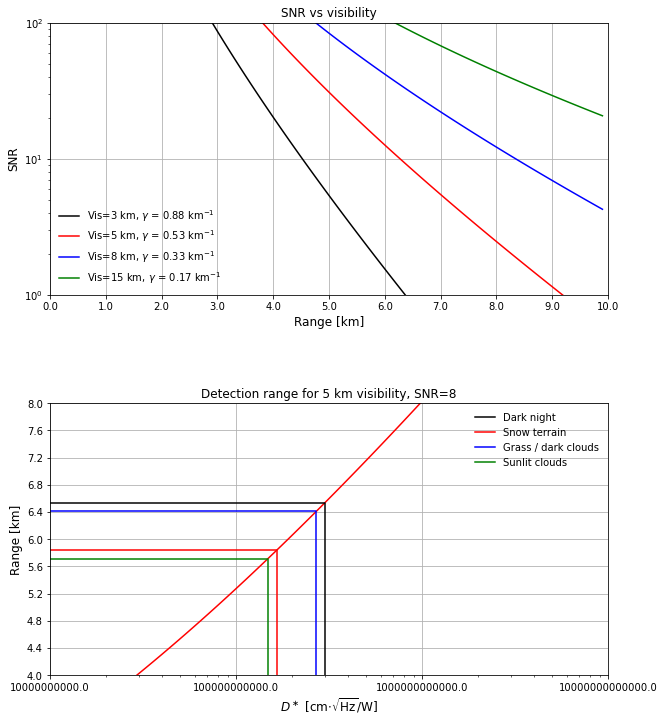

In [5]:
# to plot range equation solution for different backgrounds
Range = np.arange(0.0001,10000,100)
rho=.1
costheta=.5
dster=3e11
knkf=1
q=0.06
ar=2e-3
tr=.5
tp=15e-9
ad=4.6e-6 # m2
ad=ad*1e4 # cm2

gammas = np.array([0.88,0.53,0.33,0.17])
visib = np.array([3,5,8,15])
pcol = ['k','r','b','g','y']

p = ryplot.Plotter(1,2,1,figsize=[10,12])
for i,gamma in enumerate(gammas):
    sn = (rho*costheta*dster*q*ar*tr*np.exp(-gamma*Range/1000))/(np.pi*(tp*ad)**(.5) * Range**2)
    p.semilogY(1,Range/1000,sn,'SNR vs visibility','Range [km]','SNR',pltaxis=[0,10,1,100],
               plotCol=pcol[i],label=[f'Vis={visib[i]} km, $\gamma$ = {gamma} km$^{{-1}}$'])
    
sn=8
gamma=.53
dstermin = 1e11
dstermax = 1e12
rngmin = 4
rngmax = 8
dster=(np.pi*(tp*ad)**(0.5) * Range**2 * sn)/(rho*costheta*q*ar*tr*np.exp(-gamma*Range/1000))
p.semilogX(2,dster,Range/1000,'Detection range for 5 km visibility, SNR=8',r'$D^\ast$ [cm$\cdot$$\sqrt{\rm Hz}$/W]','Range [km]',
           pltaxis=[dstermin,dstermax,rngmin,rngmax],plotCol=pcol[1],xScientific=True)

dstar = np.array([3, 1.67, 2.7, 1.48]) * 1e11    
dslabels = ['Dark night','Snow terrain','Grass / dark clouds','Sunlit clouds']
tauTable = interp1d(dster, Range/1000,  kind = 'linear')

for i,ds in enumerate(dstar):
    rng = tauTable(ds)
    yval = np.array([rng, rng,rngmin])
    xval = np.array([dstermin/10,ds,ds])
    p.semilogX(2,xval,yval,plotCol=pcol[i],pltaxis=[dstermin,dstermax,rngmin,rngmax],label=[dslabels[i]],xScientific=True);


### Specular Reflection

![reflection-geometry.png](images/reflection-geometry.png)

This material is taken verbatim from \cite{willers2013}.

The geometry describing reflection is shown in the figure above. 
Let the incident ray be defined by the unit vector $\widehat{I}$, the surface normal vector by the unit vector $\widehat{N}$, and the reflected ray vector by the unit vector $\widehat{R}$. It is shown in Appendix~\ref{chap:vectorraytrace} that the direction of the reflected ray is given by $\widehat{R}=\widehat{I}-2(\widehat{I}\cdot\widehat{N})\widehat{N}$.\index{reflectance!Snell's law} In this definition $\widehat{R}$ represents the mirror reflection vector from the surface.
Consider now the direction of the measured flux as reflected along any arbitrary vector $\widehat{S}$. The vector $\widehat{S}$ has an angle $\alpha$ with respect to the mirror reflection vector $\widehat{R}$ (where $\cos\alpha=\widehat{S}\cdot\widehat{R}$) and an angle $\theta_s$ with respect to the surface normal vector $\widehat{N}$ (where $\cos\theta_s=-\widehat{S}\cdot\widehat{N}$).
The incident ray vector $\widehat{I}$ has an angle $\theta_i$ with respect to the surface normal vector $\widehat{N}$ (where $\cos\theta_i=-\widehat{I}\cdot\widehat{N}$).
The mirror reflected ray vector $\widehat{R}$ has an angle $\theta_r$ with respect to the surface normal vector $\widehat{N}$ (where  $\cos\theta_r=\widehat{R}\cdot\widehat{N}$).

The $\textrm{BRDF}$ \cite{Nicodemus1977,Palmer2009} defines how light is reflected at an irregular or rough surface, with or without a specular component. $\textrm{BRDF}$  varies with wavelength ---  in the following discussion the monochromatic $\textrm{BRDF}$ at a single  wavelength is considered.


$\textrm{BRDF}$  is defined as the ratio of reflected radiance $L_{\widehat{S}}(d\omega_s)$ in a small solid angle $d\omega_s$ along a view vector $\widehat{S}$ to the incident irradiance $E_{\widehat{I}}(d\omega_i)$ in a small solid angle $d\omega_i$ along the incidence vector $\widehat{I}$.  Note that an infinitesimally small solid angle $d\omega_i$ is considered and furthermore that the source surface with radiance $L_{\widehat{I}}$ uniformly fills $d\omega_i$; hence the source surface orientation is irrelevant, and   $L_{\widehat{I}}d\Omega_i=L_{\widehat{I}}d\omega_i$.

As shown in the figure, the direction of each of the two small solid angles is defined by the respective azimuth angles $\varphi_i$ and $\varphi_s$  and the zenith angles $\theta_i$ and $\theta_s$. $\textrm{BRDF}$ is therefore a four-dimensional function. Defined as $L/E$, $\textrm{BRDF}$ has units of [1/sr]:
\begin{equation}
\textrm{BRDF}=f_r(d\omega_i \rightarrow d\omega_s) = \frac{L_{\widehat{S}}(d\omega_s)}{E_{\widehat{I}}(d\omega_i)}
=\frac{L_{\widehat{S}}(d\omega_s)}{L_{\widehat{I}}(d\omega_i)\cos\theta_i d \omega_i}.\label{eq:brdfdefi}
\end{equation}
Some $\textrm{BRDF}$s are isotropic when rotated around the normal $\widehat{N}$, yielding a three-dimensional function $f_r(\theta_i, \theta_s,\varphi_i-\varphi_s) $, whereas others are anisotropic.



The Phong model, a simplified model for $\textrm{BRDF}$, is often used in computer graphics applications. The Phong model is not a mathematically rigourous model, it does not satisfy the strict $\textrm{BRDF}$ definition, but it is simple and sufficient for most purposes.
\begin{equation}
f_{r\textrm{Phong}} = \frac{L(d\omega_s)}{E(d\omega_i)} = \frac{\rho_d}{\pi}  + \frac{\rho_s(1+n)}{2\pi\cos\theta_t}\cos^{n}(\alpha)
\end{equation}
The radiance $L$ in direction of $d\omega_s$ from the surface, given irradiance $E$ from $d\omega_i$ is then given by 
\begin{equation}
L(d\omega_s) 
= E (d\omega_i)\tau_i\left(\frac{\rho_d}{\pi}  + \frac{\rho_s(1+n)}{2\pi\cos\theta_t}\cos^{n}(\alpha)\right)
= \left[L(d\omega_i)\cos\theta_i \tau_i\right] d \omega_i\left(\frac{\rho_d}{\pi}  + \frac{\rho_s(1+n)}{2\pi\cos\theta_t}\cos^{n}(\alpha)\right)
\end{equation}
where
$\tau_i$ is the atmospheric transmittance between the illuminator and the target,
$L(d\omega_i)$ is the source radiance,
$\cos\theta_i$ is the cosine of the angle between the source and the surface normal, and 
$d \omega_i$ is the solid angle subtended by the source from the target surface.


If the source can be represented by an impulse from one direction only (i.e., sun or laser illumination) with no significant other irradiance components and we can only consider a single incoming 'beam'.


A few examples of Phong BRDF is shown here:

![phong-examples.png](images/phong-examples.png)



The flux transfer from a Lambertian-reflected laser spot to the sensor is given by \cite{willers2013}:

\begin{equation}
\phi 
= \tau_a(R)\rho\left(\frac{LA_t\cos\theta_tA_0\cos\theta_0 }{R^2}\right)
\end{equation}
where $\rho$ is the diffuse Lambertian reflectance and $\tau_a$ is the atmospheric transmittance between the target and the sensor. The other terms in the bracket on the left are defined in \cite{willers2013}.

Inserting the BRDF radiance term and changing the notation a little. 
\begin{equation}
\phi  
=  \tau_a(R)\left[L_i \cos\theta_t d \omega_i\tau_i\left(\frac{\rho_d}{\pi}  + \frac{\rho_s(1+n)}{2\pi\cos\theta_t}\cos^{n}(\alpha)\right)\right]\left(\frac{A_t \cos\theta_t A_0 \cos\theta_0}{R^2}\right)
\end{equation}
where 
$L_i$ is the illuminating source radiance,
$d \omega_i$ is the illuminating source solid angle subtended at the target,
$A_t$ is illuminated spot (target) size,
the term in the square brackets on the left is the reflectance and $\tau_a$ is the atmospheric transmittance between the target and the sensor. 

Verify the above function with the the simplified Lambertian sun reflectance model where  $\rho_s=0$.
The sun solid angle is $\omega_\textrm{sun}=A_\textrm{sun}/R^2_\textrm{sun}$.
Next note that $L_\textrm{sun} \cos\theta_t d \omega_\textrm{sun}\tau_i = E_\textrm{sun}$ and for a Lambertian reflector with unity reflectivity $E_\textrm{sun}/\pi=L_\textrm{reflsun}$.  All of this yields the correct flux transfer equation.

\begin{equation}
\phi  \tau_a(R)
=  \tau_a(R)\left[L_\textrm{sun} \cos\theta_t d \omega_\textrm{sun}\tau_i\left(\frac{\rho_d}{\pi} \right)\right]\left(\frac{A_t \cos\theta_t A_0 \cos\theta_0}{R^2}\right)
 =  \tau_a(R)\rho_d \left(\frac{L_\textrm{reflsun}A_t \cos\theta_t A_0 \cos\theta_0}{R^2}\right)
\end{equation}



Assuming target image on the sensor optical axis, $\cos\theta_0=1$. Also the illuminator irradiance at the target is $E_\textrm{illum} = L_i\cos\theta_i d \omega_i\tau_i$
Then the irradiance at the sensor becomes

\begin{equation}
E 
=  \left(\frac{\rho_d}{\pi}  + \frac{\rho_s(1+n)}{2\pi\cos\theta_t}\cos^{n}(\alpha)\right)\left(\frac{E_\textrm{illum}A_t\cos\theta_t\tau_a(R)}{R^2}\right)
\end{equation}

It the laser source and sensor are coaxial (laser rangefinder), then $\alpha=2\theta_t$.

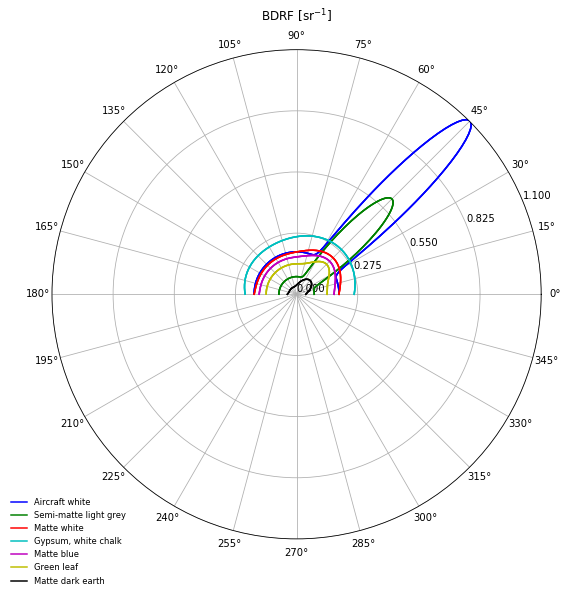

In [49]:
# to plot BRDF
# 0 = \rho_d
# 1 = \rho_s
# 2 = n
# 3 = ID

matl=np.array([
[0.11,  0.033,   6. ],
[0.52,  0.022,   8. ],
[0.58,  0.03,    6. ],
[0.25,  0.052,  44. ],
[0.6,   0.05,   80. ],
[0.33,  0.,      0. ],
[0.49,  0.,      0. ],
[0.43,  0.015,  15. ],
[0.77,  0.044,   3. ],
[0.05,  0.39,  160. ],
[0.55,  0.,      0. ],
])
matlnames = [
    'Matte dark earth',
    'Matte blue',
    'Matte white',
    'Semi-matte light grey',
    'Aircraft white',
    'Natural soil',
    'Sea sand',
    'Green leaf',
    'Gypsum, white chalk',
    'Zn coated steel'
    'Concrete']

q = ryplot.Plotter(2,1,1);
alpha = np.arange(0,np.pi, 0.01)
theta = np.pi/4
for i in [4,3,2,8,1,7,0]:
    rhod = matl[i,0]
    rhos = matl[i,1]
    n = matl[i,2]
    matlname = matlnames[i]
    bdrf = rhod / np.pi + ((1+n)*rhos/(2*np.pi*np.cos(theta) )) *  (np.cos(alpha-theta))**n
    q.polar(1,alpha,bdrf,'BDRF [sr$^{-1}$]',rscale=[0, 1.1],thetagrid=[15],label=[matlnames[i]])

The flux transfer equation can also be manipulated slightly differently. Starting from 
\begin{equation}
\phi  
=  L_i \cos\theta_t d \omega_i\tau_i\left(\frac{\rho_d}{\pi}  + \frac{\rho_s(1+n)}{2\pi\cos\theta_t}\cos^{n}(\alpha)\right)\left(\frac{A_t \cos\theta_t A_0 \cos\theta_0\tau_a(R)}{R^2}\right)
\end{equation}
and assuming that the spot or target image is on the optical axis, and noting that the illuminator power is given by $\phi_i = L_i d \omega_i A_t$, the irradiance at the sensor can be found as

\begin{equation}
E 
=   \phi_i \cos\theta_t \tau_i  \cos\theta_t\left(\frac{\rho_d}{\pi}  + \frac{\rho_s(1+n)}{2\pi\cos\theta_t}\cos^{n}(\alpha)\right)\left(\frac{ \tau_a(R)}{R^2}\right)
\end{equation}

If the illuminator is coaxial and co-located with the sensor $\tau_i=\tau_a(R)$, $\theta_i=\theta_t$, and $\alpha=2\theta$ then

\begin{equation}
E 
=   \phi_i \cos\theta^2_t \left(\frac{\rho_d}{\pi}  + \frac{\rho_s(1+n)}{2\pi\cos\theta_t}\cos^{n}(2\theta_t)\right)\left(\frac{ \tau_a^2(R)}{R^2}\right)
\end{equation}
This equation can be used to solve the laser rangefinder operating distance for $\textrm{BRDF}$ surfaces, by solving for $R$ in 
\begin{equation}
\frac{E}{\phi_i \cos\theta^2_t \left(\frac{\rho_d}{\pi}  + \frac{\rho_s(1+n)}{2\pi\cos\theta_t}\cos^{n}(2\theta_t)\right)} 
=   \left(\frac{ \tau_a^2(R)}{R^2}\right)
\end{equation}

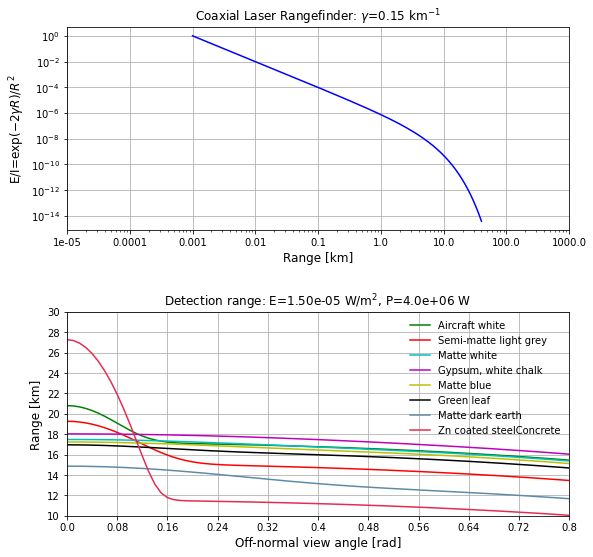

In [54]:
# to solve for rangefinder equation with BRDF

# the following applies only to a coaxial system

gamma=0.00015
powr=4e6
ESNR = 15e-6

p = ryplot.Plotter(1,2,1);
d = np.linspace(1,40e3,1000)
tabl = np.exp(-2*gamma*d)/(d*d)
tauTable = interp1d(tabl, d, kind = 'linear')
p.logLog(1,d/1000,tabl,f'Coaxial Laser Rangefinder: $\gamma$={1000*gamma} km$^{{-1}}$ ','Range [km]','$\exp(-2\gamma R)/R^2$');

theta = np.arange(0,np.pi/2, 0.01)
for i in [4,3,2,8,1,7,0,9]:
    rhod = matl[i,0]
    rhos = matl[i,1]
    n = matl[i,2]
    matlname = matlnames[i]
    bdrf = rhod  / np.pi + ((1+n)*rhos/(2*np.pi*np.cos(theta))) *  (np.cos(2*theta))**n
    factr = ESNR /(bdrf*powr * (np.cos(theta))**2)
    factr = np.where(factr>0,factr,np.min(tabl))
    dr = tauTable(factr)
    p.plot(2,theta,dr/1000,f'Detection range: E={ESNR:.2e} W/m$^2$, P={powr:.1e} W',
           'Off-normal view angle [rad]','Range [km]',
           pltaxis=[0,0.8,10,30],label=[matlname])

# Python and module versions, and dates

In [ ]:
print(ryutils.VersionInformation('matplotlib,numpy'))
